In [1]:
using Revise # Run this first, if you intend to develop the package

In [2]:
# unnecessary if you follow README
# using Pkg
# Pkg.activate("../QControl")
# Pkg.instantiate()

# Imports

In [3]:
using QControl

In [4]:
const QC = QControl;

In [5]:
using QuantumOptics
using PyPlot
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
const TO = TrajectoryOptimization
const RD = RobotDynamics
;

In [6]:
# using PyCall;
# only needed once
# using Conda;
# Conda.add("qutip");
# Conda.add("imageio");

# Set up Dynamics

In [22]:
"""
Here, we use the following augmented state and augmented controls choice, and optimizer params.

```
astate = [ψ_state]
acontrol = [controls]
```
where `controls = [uᵣ₁, uᵢ₁]`

This augmented state and control technique is based on work 
in Propson, T. et al. Physical Review Applied 17 (2022).
"""

bq_single = SpinBasis(1//2)
H₀_single = 2*π*.01*dm(spinup(bq_single))
Hcs_single = [sigmax(bq_single)/2]
ψi_single = [spinup(bq_single)]
ψt_single = [-spinup(bq_single)]

N = 1001 # number of time steps
tf = 3.0 # ns, total time
dt = tf / (N-1) # time step
amp_scale = 0.0001

control_derivative_range = (0,0)
;

In [24]:
RD.state_dim(::QC.QuantumState), RD.control_dim(::QC.QuantumState), dynamics_func, astate_initial, astate_target = QC.gen_LQR_params(bq_single, H₀_single, Hcs_single, ψi_single, ψt_single, control_derivative_range=control_derivative_range)
RD.dynamics(qs::QC.QuantumState,x,u) = dynamics_func(qs::QC.QuantumState,x,u)
;

In [25]:
model = QC.QuantumState();
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)
;

In [26]:
Q, R = gen_default_QR(state_dim, control_dim; N=N, tf=tf, amp_scale=amp_scale, control_derivative_range=control_derivative_range)
R

2×2 Matrix{Float64}:
 0.0001  -0.0
 0.0      0.0001

In [27]:
obj = gen_default_objective(state_dim, control_dim, astate_target; N=N, tf=tf, amp_scale=amp_scale, control_derivative_range=control_derivative_range)

Objective

In [28]:
# Add in normalization constraint and goal constraint
cons = ConstraintList(state_dim, control_dim, N)
# normcon = NormConstraint(state_dim, control_dim, 1.0, Equality(), :state)
# add_constraint!(cons, normcon, N)


# normcon = NormConstraint(state_dim, control_dim, π/3*2, Equality(), :control)
# add_constraint!(cons, normcon, N)

goalcon = GoalConstraint(astate_target)
add_constraint!(cons, goalcon, N)

In [29]:
prob = Problem(model, obj, astate_initial, tf, xf=astate_target, integration=RD.RK4(model), constraints=cons);

In [30]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [31]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-8

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=false);

In [32]:
solve!(solver);

┌ Warning: A not upper triangular. Creating a new upper-triangular matrix.
└ @ Altro.Cqdldl /Users/phionx/.julia/packages/Altro/jipqO/src/qdldl.jl:156


In [33]:
status(solver)

SOLVE_SUCCEEDED::TerminationStatus = 2

In [34]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 19
Final cost: 0.3124256904107485
Final constraint satisfaction: 1.1464162952279366e-12


# Save Data

In [35]:
# save data (uncomment to save)
save_solver_data(solver, label="data/cz_pulse")

In [36]:
# load data
data = load_solver_data("data/cz_pulse.jld2")

Dict{String, Vector} with 2 entries:
  "acontrols" => SVector{2, Float64}[[2.72535, 1.50394], [2.72505, 1.50447], [2…
  "astates"   => SVector{4, Float64}[[1.0, 6.16376e-18, 2.48181e-17, -8.67362e-…

# Parse Data

In [37]:
astates = data["astates"]
acontrols = data["acontrols"]
Xqv = states_to_kets(map(astate -> astate[1:4], astates), bq_single)
Ucv = controls_to_amplitudes(acontrols)
ts = dt*(1:N)
;

# Analyze States

In [38]:
println(Xqv[1])
println(Xqv[end])

Ket(dim=2)
  basis: Spin(1/2)
     1.0 + 2.0e-17im
 1.0e-17 - 0.0im
Ket(dim=2)
  basis: Spin(1/2)
 -1.0 + 4.0e-17im
 -0.0 - 0.0im


In [39]:
# szt = map(qv -> real(expect(sigmaz(bq_single),qv)), Xqv);
r1t = map(qv -> real(qv.data[1]), Xqv);
i1t = map(qv -> imag(qv.data[1]), Xqv);
leakaget = map(qv -> abs(qv.data[2]), Xqv);

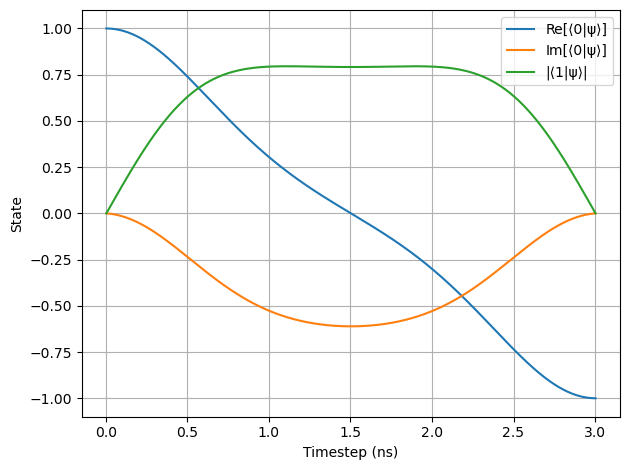

In [40]:
ts = 1:N
plot(dt*ts, r1t, label="Re[⟨0|ψ⟩]")
plot(dt*ts, i1t, label="Im[⟨0|ψ⟩]")
plot(dt*ts, leakaget, label="|⟨1|ψ⟩|")
xlabel("Timestep (ns)")
ylabel("State")
grid("on")
legend()
tight_layout()

In [41]:
szt = map(qv -> real(expect(sigmaz(bq_single),qv)), Xqv);

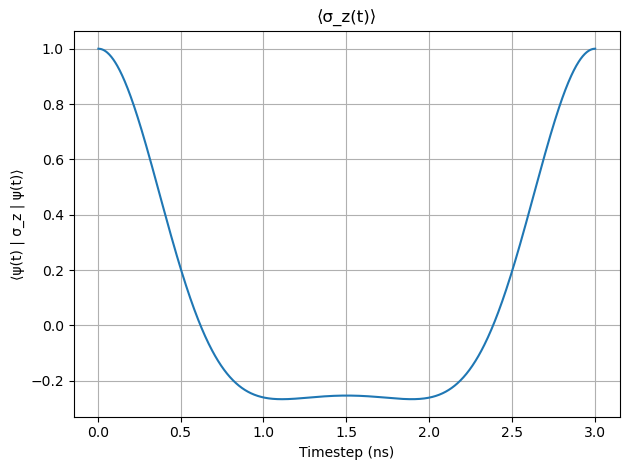

In [42]:
ts = 1:N
plot(dt*ts, szt)
xlabel("Timestep (ns)")
ylabel("⟨ψ(t) | σ_z | ψ(t)⟩")
title("⟨σ_z(t)⟩")
grid("on")
tight_layout()

# 3ns * 1.2 = pi

# Analyze Controls

In [43]:
function plot_control(controls, ts; label::String="u", index::Int = 1)    
    Ucv = map(cv -> cv[index], controls)
    Urv = map(cv -> real(cv), Ucv)
    Uiv = map(cv -> imag(cv), Ucv)
    Uav = map(cv -> norm(cv), Ucv)
    figure()
    plot(ts, Urv, label=string("Re[", label,"(t)]"))
    plot(ts, Uiv, label=string("Im[", label,"(t)]"))
    xlabel("Timestep (ns)")
    ylabel(string(label, "(t)"))
    legend()
    grid("on")
    tight_layout()
end

plot_control (generic function with 1 method)

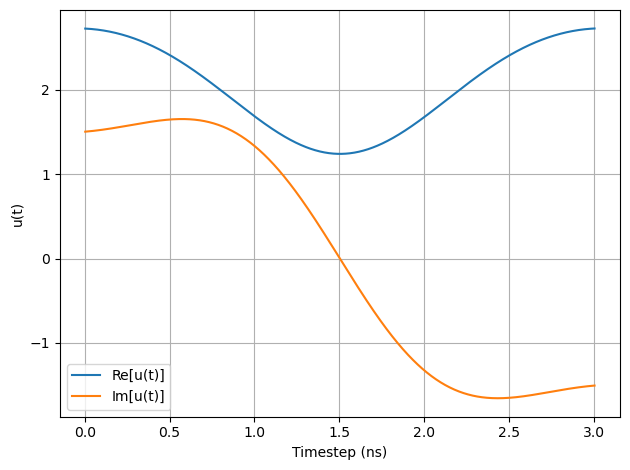

In [65]:
dt_control = dt*N/(N-1)
plot_control(Ucv, (1:N-1)*dt_control, label="u")

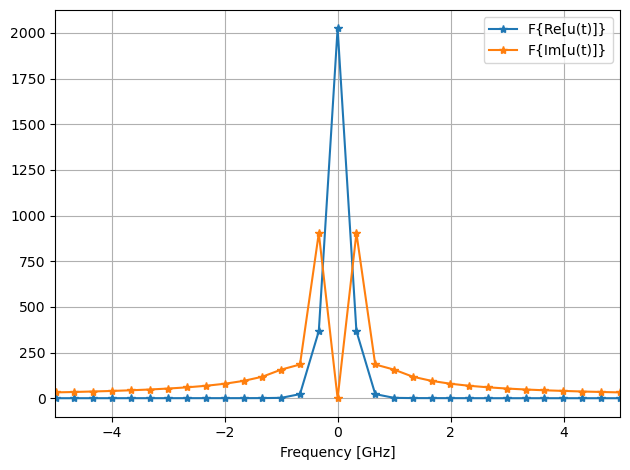

In [66]:
plot_fft(map(cv -> cv[1], Ucv), dt_control, tf)

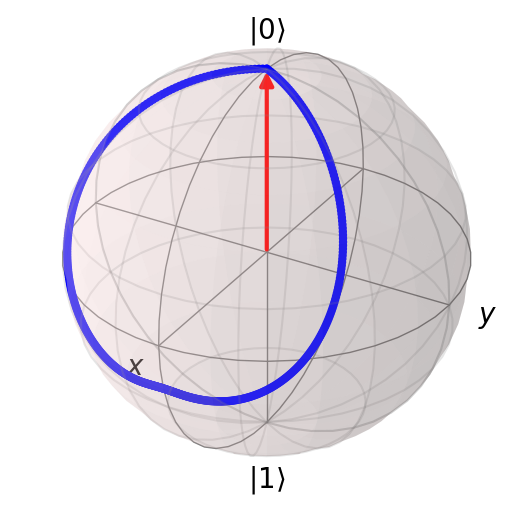

PyObject <qutip.bloch.Bloch object at 0x1a947b910>

In [46]:
animate_bloch(Xqv[1:2:end], duration=0.03, save_all=true)

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)